<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/V4_Model_under_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## relations
###  S(t) = M(t) + W(t)
###  Recovery length for each type is different 
###  K is the distribution of the number of the sever cases that need ventilators

In [0]:
## Testin Dynamics model

### Testing / population
### Testing ==> Positive / Negative
##### Pisitive case in MILD cases (X_m(t)) / Pisitive case in Severe cases (X_s(t)1)
### back tracking to see the distribution  number of the asymptomatics
### T(t

### figuring out the) = W(t) + X_m(t) * M(t)
### There should be a relation between the number of the tested cases and all the symptomatic cases

##
##                                         | Recovery process R(t+dt)
##                               | M(t) ---
##                       | P(t)---          | Goes sever W(t)
# Ex(t)->A(t)->(G_t) -S(t)        |
##                       |        | W(t) ---| Recovery process  R(t+dt)
##                       |                  | Goes Ventilatoe V(t) with distribution k(t-t')
##                       |                                               |V(t)--------| Recovery process R(t+dt2) with time. R(t+dt')
##                       |                                                            | Death 
##                       |
##                       | N(t)                    

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import swifter

In [30]:
pip install swifter

     |████████████████████████████████| 450kB 2.8MB/s 
     |████████████████████████████████| 614kB 44.2MB/s 
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=272677 sha256=74d2c904c81b1f62c24ee0831a7846acabe07555da21f8c963ae72dd6e599732
  Stored in directory: /root/.cache/pip/wheels/d7/69/b4/3200b95828d1f0ddb3cb5699083717f4fdbd9b4223d0644c57
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=379b41256b5c35d22eae12420c6eaa3d0fff1c0caae0be23ec35ae09b778ce43
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built psutil locket
ERROR: distributed 2.14.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1

In [0]:
## public variables
population = 50000
##### Percentages:
Ex_to_A = .60  ## exposed to asymptomatic (epsilon)
A_to_S = .90  ## Asymptomatic to Symptomatic  
S_to_M = .999 ## percentage from Sympt to Mild ~~100%
M_to_W = .1   ## Mild to Severe daily percentage
W_to_V = .06  ## sever to ventilator
W_to_D = .04  ## Sever to death each day
W_to_R = .30  ## Sever  to recovery each day
V_to_D = .10  ## Ventilator to death each day
V_to_R = .20  ## Ventilator to recovery each day


##### Final states

delay_Ex_to_none= 14
delay_A_to_S = 3   ## days incubation incubation period: the period of time between exposure to an infection and when symptoms
Max_S_to_M = 5  ## days incubation incubation period: the period of time between exposure to an infection and when symptoms
delay_M_to_R = 10 ## days mild to recovery ==> after this many days the mild case is considered recovered
delay_M_to_W = 4
Min_W_to_V = 2   ## days severe to ventilator 
Min_W_to_R = 10
Min_W_to_D = 3
Min_V_to_D = 1 ## days ventilator to death
delay_W_to_R = 12 ## days mild to recovery
delay_V_to_R = 16 ## days mild to recovery

## public functions
## this function returns True or False based on a percentage of probability
def decision(probability):
    return random.random() < probability

## transition rate
TR_RATE = .3


In [0]:
def initialize(inital_expose=10):

  Ex =np.int16(np.zeros(population)) ## Exposed 
  A = np.int16(np.zeros(population)) ## number of asymptomatic cases at time t
  S = np.int16(np.zeros(population)) ## number of symptomatic cases at time t
  M = np.int16(np.zeros(population)) ## number of mild cases at time t
  W = np.int16(np.zeros(population)) ## number of sever cases at time t  
  V = np.int16(np.zeros(population)) ## number of the ventilator cases 
  D = np.int16(np.zeros(population)) ## number of the dead cases
  R = np.int16(np.zeros(population)) ## Recovered cases
  H = np.int16(np.ones(population)) ## Number of Healthy


  ## random exposed people:
  for i in range(inital_expose):
    Ex[np.random.randint(0,population,1)]=1

  ## moving status Matrix:
  df_s_m = pd.DataFrame({
     "Exposed"    : Ex,
     "Asympt"     : A,
     "Sympt"      : S,
     "Mild"       : M,
     "Severe"     : W,
     "Ventilator" : V,
     "Dead"       : D,
     "Recovered"  : R,
     "Healthy"    : H
  })
  
  return df_s_m
 

In [0]:
def check_increment(df_,col,lim_=0):
  temp_count = 0
  temp_count = df_[df_[col]>0][col].count()
  return temp_count

def aggregate(df_population,cum_sum_dict):

  for col in df_population.columns:
    cum_sum_dict[f'cumulative_{col}'].append(check_increment(df_population.copy(),col))
  return cum_sum_dict

def run_simulation(df_population,length=60):

  cum_sum_dict={
      "cumulative_Exposed"   :[],
      "cumulative_Asympt"    :[],
      "cumulative_Sympt"     :[],
      "cumulative_Mild"      :[],
      "cumulative_Severe"    :[],
      "cumulative_Ventilator":[],
      "cumulative_Dead"     :[],
      "cumulative_Recovered" :[],
      "cumulative_Healthy"   :[]
    }


  for i in tqdm.tqdm_notebook(range(length)):

      df_population = df_population.swifter.apply(increment_infected_days,axis=1) ## apply the function
      aggregate(df_population,cum_sum_dict)
      #if total_infected>0:
      #  print(total_infected, total_recovered,total_dead)

  
  return cum_sum_dict



In [0]:
## simmulate based on each day's cases and the probability of infection


def increment_infected_days(row):
  
  global total_infected
  global total_recovered
  global total_dead
  global total_ventilatored


  if (row['Exposed'] >0) & (row['Exposed'] <= delay_Ex_to_none) : 
    ## increment t+1
    row['Exposed'] = row['Exposed']+1
## if exposed=0 then the person is not exposed yet, 
## if exposed above 1, it shows the days from exposure 
## if exposed = -1, the person is infected                       
### if exposed ===> epsilon * E is the percentage of the person exposed to be infected 
###  decision ---> uniform random numbers and percentage
    if decision(Ex_to_A) == True:
      total_infected=total_infected+1
## the exposed person is infected now (Asympt)!
      row['Asympt'] = 1
      row['Healthy']=0


##Take the person out of exposed group -epsilon*E
      row['Exposed'] = -1
  elif row['Exposed'] == -1:
    if row['Asympt']> 0:
      row['Asympt']=row['Asympt']+1 ## t=t+1
      ## if Asympt=0 then the person is not exposed yet, 
      ## if Asympt above 1, it shows the days from Asympt 
      ## if Asympt = -1, the person is now out of Asympt ==> Mild
      if row['Asympt'] > delay_A_to_S: ### the period from A to S is done:
        row['Asympt'] = -1 ## not the case is no more Asympt 
        if decision(A_to_S) == True: ## the pecentage from A to S
          row['Sympt'] = 1
        else:
          row['Recovered'] = 1 ## if the max time from A to S passes
                                 ## and the decision is Negative
                                 ## the person is not recovered
          total_infected = total_infected-1
          total_recovered = total_recovered + 1 



  elif row['Exposed'] >= delay_Ex_to_none:
        print('delay_Ex_to_none')
        row['Exposed'] = 0

  if row['Sympt'] > 0:
    row['Sympt']= row['Sympt']+1 ## t=t+1 ==> the person is not infected and has sympt
    ## let us take him into mild if the max time from S to M is not passed 
    if row['Sympt'] < Max_S_to_M:
      if decision(S_to_M) == True:
        row['Mild'] = 1
        row['Sympt'] = -1 ## case is now Mild and no more S 
      else: ## the Sympt person does not become Mild in Max_S_to_M he is considered recovered
        row['Sympt'] = -1 ## case is now recovered
        row['Recovered'] = 1 ## if the Max_S_to_M is passed the person has already recovered
        total_infected = total_infected - 1
        total_recovered = total_recovered + 1


  if row['Mild']>0:
    row['Mild']=row['Mild']+1 ## t=t+1    
    if row['Mild'] > delay_M_to_R : # the case hastotal_infected = total_infected + 1  already been long in mild, and now is recovered
      row['Mild'] = -1 ## case is no more infected in mild and is recovered
      row['Recovered'] = 1 
      ### before the recovery period is passed
      ### after the window from M to W
      ## the person has M_to_W chance to go to SEVERE every day before the period
      total_infected = total_infected - 1 
      total_recovered = total_recovered + 1

    elif (row['Mild'] <= delay_M_to_R) &(row['Mild'] >= delay_M_to_W) & decision(M_to_W) == True: 
      row['Mild'] = -1 ## the case is no more Mild and now is severe
      row['Severe'] = 1 ## the case is now severe

  if row['Severe'] > 0: ## check if the person is Severe
    #print(f'Condition 1 {row["Severe"]}')
    row['Severe'] = row['Severe'] + 1
    

    if row['Severe'] > delay_W_to_R: ## the case has been passed the period and now has recovered
      row['Severe'] = -1 ## the case is no more Severe and has recovered
      row['Recovered'] = 1
      total_infected = total_infected - 1
      total_recovered = total_recovered + 1
      
    elif (row['Severe'] > Min_W_to_V ) & decision(W_to_V)==True: ## in the period to go worse or stay sever until recovery/death
    ## goes to Ventilator status
      row['Severe'] = -1 ## the case is no more Severe 
      row['Ventilator'] = 1  ## the case is ventilatored
    elif (row['Severe'] > Min_W_to_R ) & decision(W_to_R)==True: ## in the period to go worse or stay sever until recovery/death
      ## goes to Ventilator status
      row['Severe'] = -1 ## the case is no more Severe 
      row['Recovered'] = 1  ## the case is ventilatored
      total_infected = total_infected - 1 
      total_recovered = total_recovered + 1

    elif (row['Severe'] > Min_W_to_D) & (decision(W_to_D)==True):
    ## the cases passes away
      row['Severe'] = -1 ## the case is no more Severe
      row['Dead'] = 1 ## the case has passed away
      total_infected = total_infected - 1
      total_dead = total_dead + 1


  if row['Ventilator'] > 1: 
    row['Ventilator'] = row['Ventilator']+1
    if row['Ventilator'] > delay_V_to_R: 
      row['Ventilator'] = -1 
      row['Recovered'] = 1
      total_infected = total_infected - 1
      total_recovered = total_recovered + 1

    elif (row['Ventilator'] > Min_V_to_D) & (decision(V_to_D)==True): 
      row['Ventilator'] = -1 
      row['Dead'] = 1 
      total_infected = total_infected - 1
      total_dead = total_dead + 1

    elif (row['Ventilator'] > Min_V_to_R) & (decision(V_to_R)==True): 
      row['Ventilator'] = -1 
      row['Recovered'] = 1
      total_infected = total_infected - 1
      total_recovered = total_recovered + 1

  ### NEW CASES HAPPEN HERE
  ## 1 get total infected now!
  ## total Mild + Total Severe
  #total_mild = df_population[df_population['Mild']>0]['Mild'].count()

  healthy_population = population - (total_recovered + total_infected + total_dead)

  if row['Exposed'] == 0:
    if decision(TR_RATE*(total_infected/healthy_population)) == True:
      row['Exposed'] = 1
  
  


  return row

In [0]:
df_population=initialize()
df_population.head(1)
total_infected = 0
total_recovered = 0
total_dead = 0
total_ventilatored = 0

In [36]:
results = run_simulation(df_population,length=80)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: ignored

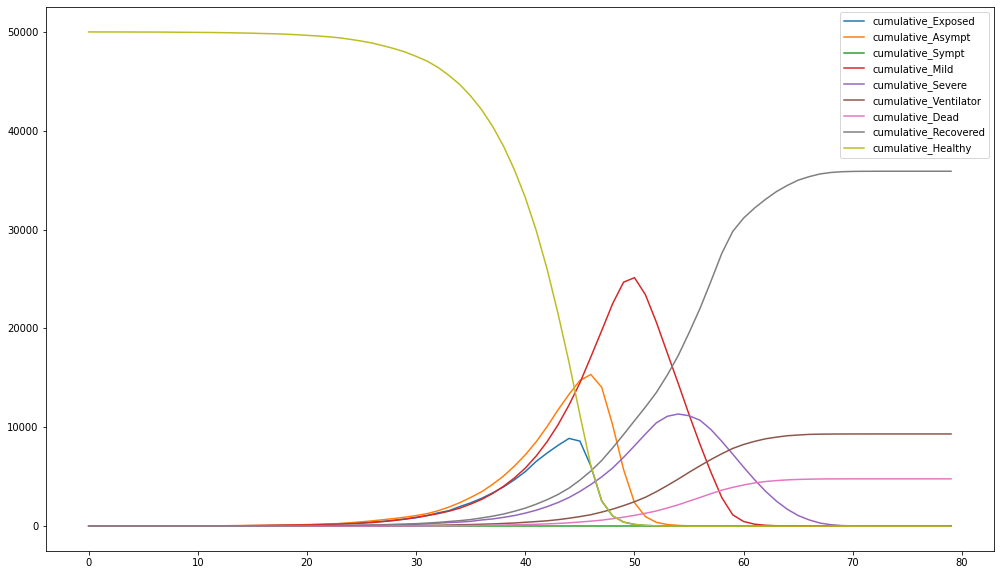

In [27]:
df_cumsum = pd.DataFrame(results)
f,ax = plt.subplots(figsize=(17,10))
df_cumsum.plot(ax=ax)

In [0]:
df_population